In [1]:
# Data Wrangling

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib jpn support
import japanize_matplotlib

# dataframe display function
from IPython.display import display

# diaply adjustment
# numpy float display adjustment
np.set_printoptions(suppress = True, precision = 4)

# pandas float display adjustment
pd.options.display.float_format = '{:.4f}'.format

# show all columns of dataframe
pd.set_option('display.max_columns', None)

# default font
plt.rcParams['font.size'] = 14

# set random number
random_seed = 123

#### Data column names Japanese

instant インデックス  
dteday 日付(yy-mm-dd)  
season 季節 (1: 冬 2: 春 3: 夏 4:秋)  
yr 年 (0: 2011, 1:2012)  
mnth 月  (1 - 12)  
hr 時間  (0 - 23)  
holiday 祝日  
weekday 曜日 (0 - 6)  
workingday  勤務日 (1: 勤務日 0: 休日)  
weathersit 天気 (1: 晴れから曇り 2: 霧 3: 小雨 4: 大雨)  
temp 気温 (正規化済み)  
atemp 体感気温 (正規化済み)  
hum 湿度 (正規化済み)  
windspeed 風速 (正規化済み)  
casual 臨時利用者数  
registered 登録利用者数  
cnt 全体利用者数  

# Data import and verification

## importance

In [2]:
# import csv
# parse_dates = specify the column representing date
df = pd.read_csv('/Users/satoshiido/Documents/Coding_general/Business_AI/data/day.csv', parse_dates = [1])

# data attribute
print(df.dtypes)

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


In [3]:
# delete `instant` column
df = df.drop('instant', axis = 1)

# transalate columns in japanese
columns = [
    '日付',  '季節',  '年', '月', '祝日', '曜日', '勤務日', '天気', 
    '気温', '体感温度',  '湿度', '風速',
    '臨時ユーザー利用数', '登録ユーザー利用数', '全体ユーザー利用数'
]

df.columns = columns

## data verification

In [4]:
# first 5 rows
display(df.head())
# last 5 rows
display(df.tail())

,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


# Data preprocessing

columns names change to use `Prophet` library
this time-series analysis is based on the belief that `登録ユーザー利用数` includes other effects came from variabes such as `気温`, `天気` and all such

In [5]:
#  extract `日付` `登録ユーザー利用数`
# create the dataframe `df2` with column `日付` as ds, `登録ユーザー利用数` as y

# copy
df2 = df.copy()

# extract `日付` and `登録ユーザー利用数` columns
df2 = df2[['日付', '登録ユーザー利用数']]

# rename columns
df2.columns = ['ds', 'y']

# results
display(df2.head())

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


## data split

train data: before 2012-11-01\
test data: after 2012-11-01

In [6]:
# split date
mday = pd.to_datetime('2012-11-1')

# train data index and test data index
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

# split input data
x_train = df2[train_index]
x_test = df2[test_index]

# split datetime data for graph
dates_test = df2['ds'][test_index]

# Algorithm selection

In [7]:
# library
from fbprophet import Prophet

# model selection
# it is important to set up three seasonality parameters
# no need for daily_seasonality since data is daily ones (no hourly data)
# Can also be specified numerically i/o True or False
# seasonality_mode: additive(defaults) multiplicative
m1 = Prophet(yearly_seasonality = True, weekly_seasonality = True, 
    daily_seasonality = False, seasonality_mode = 'multiplicative')

Importing plotly failed. Interactive plots will not work.


# Learning and prediction

In [8]:
# learning
m1.fit(x_train)

Initial log joint probability = -13.126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       1202.95   0.000729002       98.0402   8.264e-06       0.001      108  LS failed, Hessian reset 
      99       1203.03   0.000185499       100.144        4.04       0.404      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       1203.24   0.000718454       101.529   6.629e-06       0.001      205  LS failed, Hessian reset 
     199       1203.47    0.00259833       91.1842           1           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1203.59   2.20741e-05        87.065      0.2914      0.2914      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       1203.59   1.37846e-07       83.8183      0.9219      0.9219      484   
Optimization terminate

In [9]:
# create future data for prediction (dataframe with only `日付 ds`)
# 61 = the number of days to be predict (2012-11-1 to 2012-12-31)
future1 = m1.make_future_dataframe(periods = 61, freq = 'D')

# results
display(future1.head())
display(future1.tail())

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [10]:
# prediction
# return as dataframe
fcst1 = m1.predict(future1)

# Evaluation

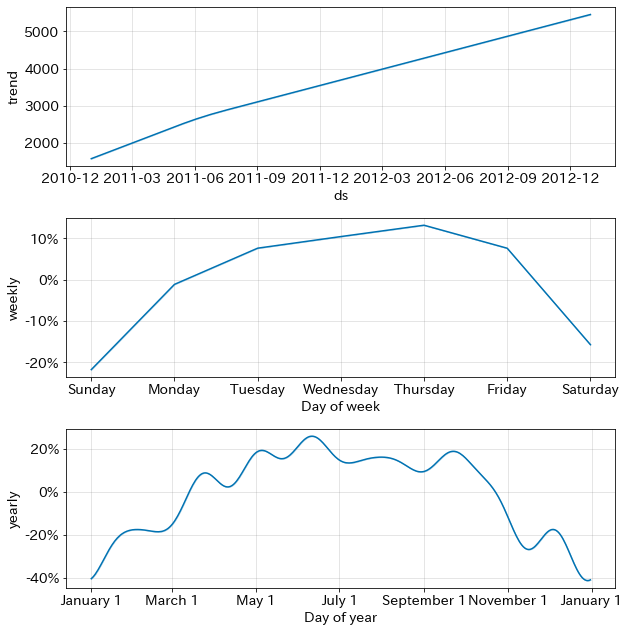

In [11]:
# graph plot by each seasonality
fig = m1.plot_components(fcst1)
plt.show()

## graph with overall train data / validation data

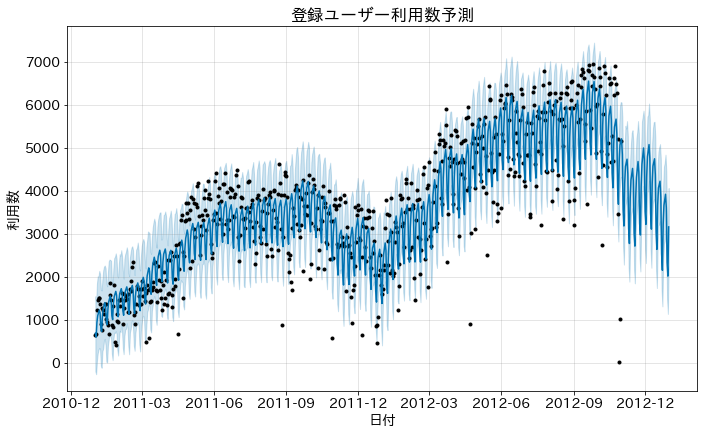

In [12]:
# graph with train data and validation data 
fig, ax = plt.subplots(figsize = (10, 6))

# show the prediction results (prophet's function)
m1.plot(fcst1, ax = ax)

# title
ax.set_title('登録ユーザー利用数予測')
ax.set_xlabel('日付')
ax.set_ylabel('利用数')

# graph
plt.show()

## $ r^2 $ calculation

In [14]:
# ypred1: extract only predicted data from fcst1
ypred1 = fcst1[-61:][['yhat']].values

# ytest1: right label data during the forecasting period
ytest1 = x_test['y'].values

#R2
from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

# results
print(f'R2 score:{score:.4f}')

R2 score:0.3732


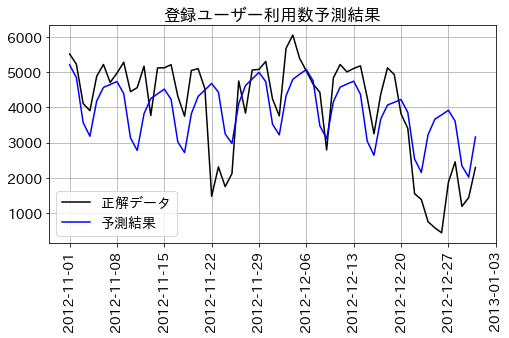

In [15]:
# graph with time-series data
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize = (8, 4))

# graph plot
ax.plot(dates_test, ytest1, label = '正解データ', c = 'k')
ax.plot(dates_test, ypred1, label = '予測結果', c = 'b')

# daily scale interval on Thursday
weeks = mdates.WeekdayLocator(byweekday = mdates.TH)
ax.xaxis.set_major_locator(weeks)

# rotation
ax.tick_params(axis = 'x', rotation = 90)

# graph paper
ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果')

# plot
plt.show()

# Tuning
- step1: set「休日」 as particular day
- step2: include 「天気」「気温」「風速」「湿度」 to a regression model

## Tuning (step1)
set and add 「休日」 as holidays

In [17]:
# extract `休日`(=holiday) data
df_holiday = df[df['祝日'] == 1]
holidays = df_holiday['日付'].values

# change to dataframe
df_add = pd.DataFrame({
    'holiday': 'holi', 
    'ds': holidays, 
    'lower_window': 0, 
    'upper_window': 0

})

#results
display(df_add.head())
display(df_add.tail())

,holiday,ds,lower_window,upper_window
0,holi,2011-01-17,0,0
1,holi,2011-02-21,0,0
2,holi,2011-04-15,0,0
3,holi,2011-05-30,0,0
4,holi,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holi,2012-09-03,0,0
17,holi,2012-10-08,0,0
18,holi,2012-11-12,0,0
19,holi,2012-11-22,0,0
20,holi,2012-12-25,0,0


In [18]:
# input = 休日(df_add) and create model

# algorithm selection
# model m2 with `holidays` parameters added
m2 = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = False,
    holidays = df_add,
    seasonality_mode = 'multiplicative'
)

# learning
m2 = m2.fit(x_train)

# prediction
fcst2 = m2.predict(future1)

Initial log joint probability = -13.126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1214.42   7.34666e-05        70.797      0.6605      0.6605      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       1214.45   1.72247e-08       88.6501      0.2069      0.2069      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### evaluation

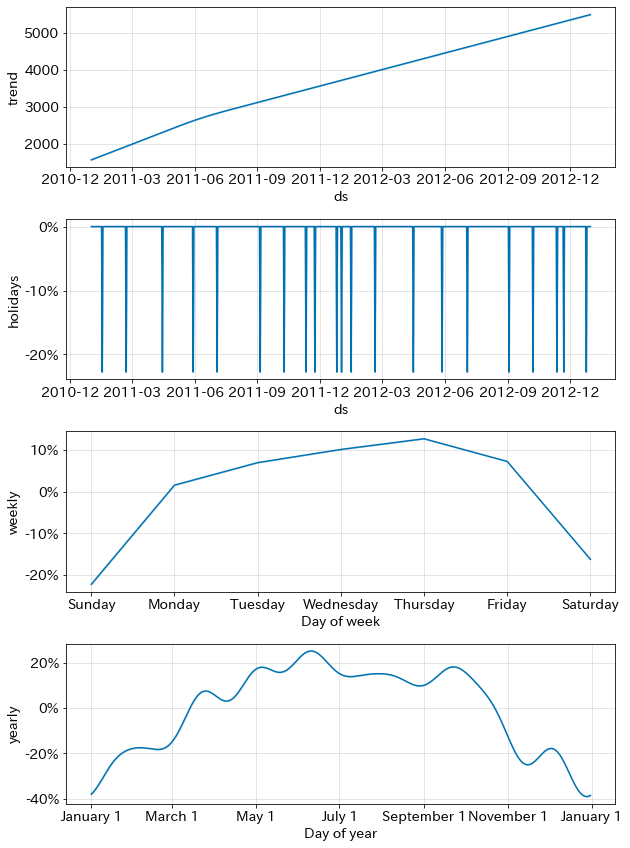

In [19]:
# graph plot by each seasonality
fig = m2.plot_components(fcst2)
plt.show()

In [23]:
# R^2 calculation

# extract predicted data from fcst2
ypred2 = fcst2[-61:][['yhat']].values

# R^2 calculation
score2 = r2_score(ytest1, ypred2)

# results
r2_text2 = f'R2 score{score2:.4f}'
print(r2_text2)

R2 score0.4145


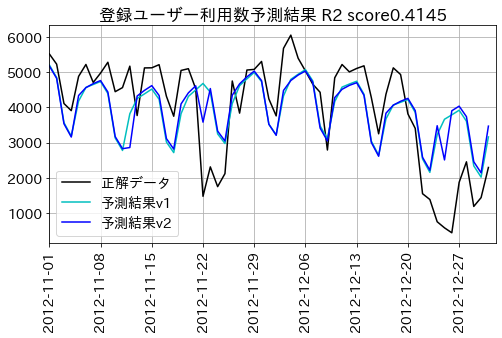

In [24]:
# time-series graph plot
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize = (8, 4))

# graph plot
ax.plot(dates_test, ytest1, label = '正解データ', c = 'k')
ax.plot(dates_test, ypred1, label = '予測結果v1', c = 'c')
ax.plot(dates_test, ypred2, label = '予測結果v2', c = 'b')

# daily scale interval on Thursday
weeks = mdates.WeekdayLocator(byweekday = mdates.TH)
ax.xaxis.set_major_locator(weeks)

# rotation
ax.tick_params(axis = 'x', rotation = 90)

# start date and end date
sday = pd.to_datetime('2012-11-1')
eday = pd.to_datetime('2013-1-1')
ax.set_xlim(sday, eday)

# graph paper
ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果 ' + r2_text2)

# plot
plt.show()

## Tuning(step2)

include「天気」「気温」「風速」「湿度」in a prediction model

In [21]:
# add 「天気」「気温」「風速」「湿度」in train data
df3 = pd.concat([df2, df[['天気', '気温', '風速', '湿度']]], axis = 1)

# split input data
x2_train = df3[train_index]
x2_test = df3[test_index]

# results
display(x2_train.tail())

,ds,y,天気,気温,風速,湿度
665,2012-10-27,5209,2,0.5300,0.2357,0.7200
666,2012-10-28,3461,2,0.4775,0.3980,0.6946
667,2012-10-29,20,3,0.4400,0.3582,0.8800
668,2012-10-30,1009,2,0.3182,0.2130,0.8255
669,2012-10-31,5147,2,0.3575,0.1667,0.6667


In [22]:
# algorithm selection
m3 = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative',
    holidays = df_add
)

# add 「天気」「気温」「風速」「湿度」 in the model by using add_regressor function
m3.add_regressor('天気')
m3.add_regressor('気温')
m3.add_regressor('風速')
m3.add_regressor('湿度')

# learning
m3.fit(x2_train)

Initial log joint probability = -13.126


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1383.13   0.000649823       87.1949      0.3712      0.3712      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1383.84   4.36299e-05       80.2869      0.6561      0.6561      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1383.85   0.000164861       81.9326   1.849e-06       0.001      289  LS failed, Hessian reset 
     252       1383.86   3.52711e-08       80.8578      0.3543      0.3543      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [26]:
# input data for prediction
future3 = df3[['ds', '天気', '気温', '風速', '湿度']]

# prediction
fcst3 = m3.predict(future3)

### Evaluation

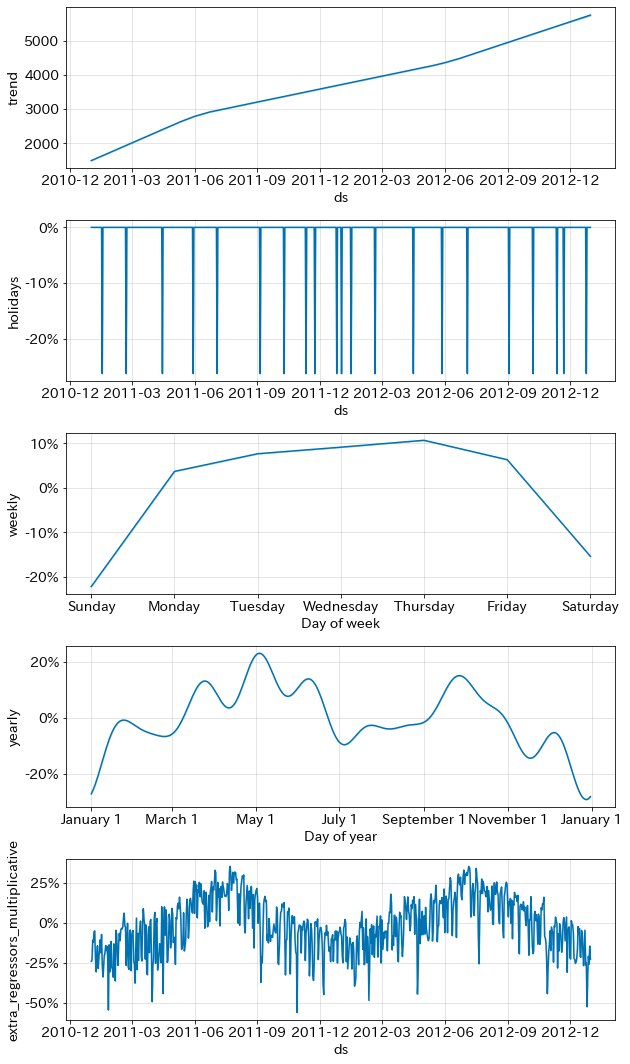

In [27]:
# graph plot by each seasonality
fig = m3.plot_components(fcst3)
plt.show()

In [28]:
# R^2 calculation

# extract predicted data from fcst2
ypred3 = fcst3[-61:][['yhat']].values

# R^2 calculation
score3 = r2_score(ytest1, ypred3)

# results
r2_text3 = f'R2 score{score3:.4f}'
print(r2_text3)

R2 score0.6189


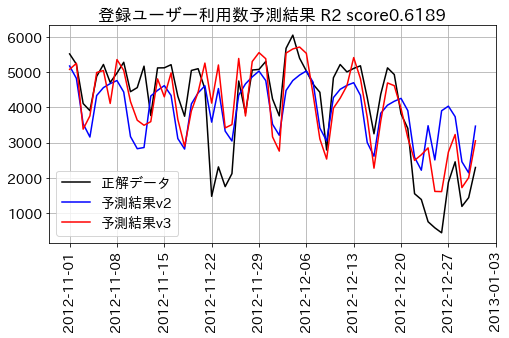

In [32]:
# time-series graph plot
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize = (8, 4))

# graph plot
ax.plot(dates_test, ytest1, label = '正解データ', c = 'k')
ax.plot(dates_test, ypred2, label = '予測結果v2', c = 'b')
ax.plot(dates_test, ypred3, label = '予測結果v3', c = 'r')

# daily scale interval on Thursday
weeks = mdates.WeekdayLocator(byweekday = mdates.TH)
ax.xaxis.set_major_locator(weeks)

# rotation
ax.tick_params(axis = 'x', rotation = 90)

# graph paper
ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果 ' + r2_text3)

# plot
plt.show()